<a href="https://colab.research.google.com/github/Rahul20037237/Build_your_own_NN/blob/main/Build_your_own_neuralNetowork_Mnist_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from tqdm.notebook import tqdm
import numpy as np
import pandas as pd
import random
from sklearn.datasets import fetch_openml
import matplotlib.pyplot as plt
import matplotlib.animation as animation

In [ ]:
class Cross_entropy:
    @staticmethod
    def fn(a, y):
        return np.sum(np.nan_to_num(-y * np.log(a) + (1 - y) * np.log(1 - a)))

    @staticmethod
    def delta(a, y):
        return a - y

In [ ]:
class NeuralNetwork:
    def __init__(self, sizes):
        self.num_layers = len(sizes)
        self.sizes = sizes
        self.biases = [np.random.randn(y, 1) for y in sizes[1:]]
        self.weights = [np.random.randn(y, x) for x, y in zip(sizes[:-1], sizes[1:])]

    def sigmoid(self, z):
        return 1 / (1 + np.exp(-z))

    def sig_diff(self, z):
        return self.sigmoid(z) * (1 - self.sigmoid(z))

    def feed_forward(self, a):
        for b, w in zip(self.biases, self.weights):
            a = self.sigmoid(np.dot(w, a) + b)
        return a

    def Acc(self, test_data, convert=False):
        if convert:
            test_data = [(np.argmax(self.feed_forward(x)), np.argmax(y)) for x, y in test_data]
        else:
            test_data = [(np.argmax(self.feed_forward(x)), y) for x, y in test_data]
        return sum(int(x == y) for x, y in test_data)

    def total_cost(self, data, lmbda, convert=False):
        cost = 0.0
        for x, y in data:
            a = self.feed_forward(x)
            if convert:
                y = self.vectorized_result(y)
            cost += Cross_entropy.fn(a, y) / len(data)
        cost += 0.5 * (lmbda / len(data)) * sum(np.linalg.norm(w) ** 2 for w in self.weights)
        return cost

    def SGD(self, training_data, epochs, mini_batch_size, eta, lmbda=0.0,
            monitor_ev_cost=False, monitor_ev_acc=False,
            monitor_train_cost=False, monitor_train_acc=False,
            test_data=None):
        if test_data:
            n_test = len(test_data)
        n = len(training_data)
        evaluation_cost, evaluation_acc = [], []
        training_cost, training_acc = [], []

        for i in range(epochs):
            random.shuffle(training_data)
            mini_batches = [training_data[j:j + mini_batch_size] for j in range(0, n, mini_batch_size)]
            with tqdm(total=len(mini_batches), desc=f"Epoch {i + 1}/{epochs}", unit="batch") as pbar:
                for mini_batch in mini_batches:
                    self.update_mini_batch(mini_batch, eta, lmbda, len(training_data))
                    pbar.update(1)
            if monitor_ev_cost:
                cost = self.total_cost(test_data, lmbda, convert=True)
                evaluation_cost.append(cost)
                print("Cost on evaluation data: {0}".format(cost))
            if monitor_ev_acc:
                acc = self.Acc(test_data, convert=False)
                evaluation_acc.append(acc)
                print("Accuracy on evaluation data: {0} / {1}".format(acc, n_test))
            if monitor_train_cost:
                cost = self.total_cost(training_data, lmbda)
                training_cost.append(cost)
                print("Cost on training data: {0}".format(cost))
            if monitor_train_acc:
                acc = self.Acc(training_data, convert=True)
                training_acc.append(acc)
                print("Accuracy on training data: {0} / {1}".format(acc, n))
            print(f"Epoch {i + 1}/{epochs} complete")
        print("Training complete")

    def update_mini_batch(self, mini_batch, eta, lmbda, n):
        nx_b = [np.zeros(b.shape) for b in self.biases]
        nx_w = [np.zeros(w.shape) for w in self.weights]
        for x, y in mini_batch:
            delta_b, delta_w = self.back_propagation(x, y)
            nx_b = [nb + db for nb, db in zip(nx_b, delta_b)]
            nx_w = [nw + dw for nw, dw in zip(nx_w, delta_w)]
        self.weights = [(1 - eta * (lmbda / n)) * w - (eta / len(mini_batch)) * nw
                        for w, nw in zip(self.weights, nx_w)]
        self.biases = [b - (eta / len(mini_batch)) * nb for b, nb in zip(self.biases, nx_b)]

    def back_propagation(self, x, y):
        nx_w = [np.zeros(w.shape) for w in self.weights]
        nx_b = [np.zeros(b.shape) for b in self.biases]
        Activation = x
        Activations = [x]
        zs = []

        # Feedforward
        for w, b in zip(self.weights, self.biases):
            z = np.dot(w, Activation) + b
            zs.append(z)
            Activation = self.sigmoid(z)
            Activations.append(Activation)

        # Backward pass
        delta = Cross_entropy.delta(Activations[-1], y) * self.sig_diff(zs[-1])
        nx_b[-1] = delta
        nx_w[-1] = np.dot(delta, Activations[-2].transpose())

        for i in range(2, self.num_layers):
            z = zs[-i]
            sp = self.sig_diff(z)
            delta = np.dot(self.weights[-i + 1].transpose(), delta) * sp
            nx_b[-i] = delta
            nx_w[-i] = np.dot(delta, Activations[-i - 1].transpose())
        return nx_b, nx_w

    @staticmethod
    def vectorized_result(j):
        e = np.zeros((10, 1))
        e[j] = 1.0
        return e


In [ ]:
def load_data():
      mnist = fetch_openml('mnist_784')
      data = mnist['data']
      labels = mnist['target'].astype(int)
      data = np.array(data) / 255
      training_data = data[:50000]
      training_labels = labels[:50000]
      validation_data = data[50000:60000]
      validation_labels = labels[50000:60000]
      test_data = data[60000:]
      test_labels = labels[60000:]
      return [training_data, training_labels], [validation_data, validation_labels], [test_data, test_labels]

def load_data_wrapper():
      tr_d, va_d, te_d = load_data()
      training_inputs = [np.reshape(x, (784, 1)) for x in tr_d[0]]
      training_results = [vectorized_result(y) for y in tr_d[1]]
      training_data = zip(training_inputs, training_results)
      validation_inputs = [np.reshape(x, (784, 1)) for x in va_d[0]]
      validation_data = zip(validation_inputs, va_d[1])
      test_inputs = [np.reshape(x, (784, 1)) for x in te_d[0]]
      test_data = zip(test_inputs, te_d[1])
      return (training_data, validation_data, test_data)
def vectorized_result(j):
      e = np.zeros((10, 1))
      e[j] = 1.0
      return e

In [ ]:
import tensorflow as tf
with tf.device('/GPU:0'):
  training_data, validation_data, test_data = load_data_wrapper()
  test_data = list(test_data)
  training_data = list(training_data)
# Initialize the neural network
  nn = NeuralNetwork([784, 30, 10])
# Train the neural network


In [ ]:
nn.SGD(training_data, epochs=10, mini_batch_size=10,lmbda=0.5,
            monitor_ev_cost=True,
            monitor_ev_acc=True,
            monitor_train_cost=True,
            monitor_train_acc=True,eta=3,test_data=test_data)

Epoch 1/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 1.8493003074846976
Accuracy on evaluation data: 7983 / 10000
Cost on training data: 1.4821857248130481
Accuracy on training data: 40161 / 50000
Epoch 1/10 complete


Epoch 2/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.5341047173976747
Accuracy on evaluation data: 9196 / 10000
Cost on training data: 0.25402019329107195
Accuracy on training data: 46306 / 50000
Epoch 2/10 complete


Epoch 3/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.42535026304212475
Accuracy on evaluation data: 9335 / 10000
Cost on training data: 0.20785511322727965
Accuracy on training data: 46980 / 50000
Epoch 3/10 complete


Epoch 4/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.3795374221044844
Accuracy on evaluation data: 9367 / 10000
Cost on training data: 0.20200970711406008
Accuracy on training data: 47193 / 50000
Epoch 4/10 complete


Epoch 5/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.27477355557435146
Accuracy on evaluation data: 9384 / 10000
Cost on training data: 0.13901400148961449
Accuracy on training data: 47371 / 50000
Epoch 5/10 complete


Epoch 6/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.2414519454412501
Accuracy on evaluation data: 9409 / 10000
Cost on training data: 0.1276077701229975
Accuracy on training data: 47459 / 50000
Epoch 6/10 complete


Epoch 7/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.23928167377104373
Accuracy on evaluation data: 9476 / 10000
Cost on training data: 0.13239523064320585
Accuracy on training data: 47850 / 50000
Epoch 7/10 complete


Epoch 8/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.1995300685924548
Accuracy on evaluation data: 9489 / 10000
Cost on training data: 0.11036208255002125
Accuracy on training data: 47877 / 50000
Epoch 8/10 complete


Epoch 9/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.1798315385605207
Accuracy on evaluation data: 9514 / 10000
Cost on training data: 0.09789618773234632
Accuracy on training data: 47990 / 50000
Epoch 9/10 complete


Epoch 10/10:   0%|          | 0/5000 [00:00<?, ?batch/s]

Cost on evaluation data: 0.20310123450086198
Accuracy on evaluation data: 9498 / 10000
Cost on training data: 0.12206956477691705
Accuracy on training data: 47922 / 50000
Epoch 10/10 complete
Training complete


30


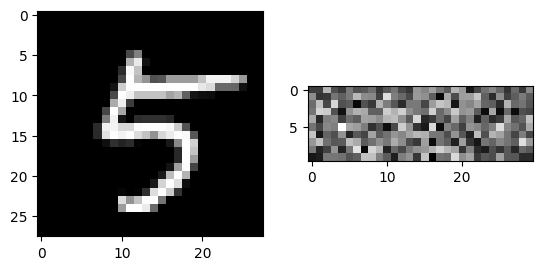

In [ ]:
image=nn.weights[1]
print(len(nn.weights[0]))
plt.subplot(1,2,1)
plt.imshow(training_data[12][0].reshape(28,28),cmap='gray')
plt.subplot(1,2,2)
plt.imshow(image,cmap='gray')
plt.show()

In [ ]:
weights=np.linspace(-1,1,50)
weights

array([-1.        , -0.95918367, -0.91836735, -0.87755102, -0.83673469,
       -0.79591837, -0.75510204, -0.71428571, -0.67346939, -0.63265306,
       -0.59183673, -0.55102041, -0.51020408, -0.46938776, -0.42857143,
       -0.3877551 , -0.34693878, -0.30612245, -0.26530612, -0.2244898 ,
       -0.18367347, -0.14285714, -0.10204082, -0.06122449, -0.02040816,
        0.02040816,  0.06122449,  0.10204082,  0.14285714,  0.18367347,
        0.2244898 ,  0.26530612,  0.30612245,  0.34693878,  0.3877551 ,
        0.42857143,  0.46938776,  0.51020408,  0.55102041,  0.59183673,
        0.63265306,  0.67346939,  0.71428571,  0.75510204,  0.79591837,
        0.83673469,  0.87755102,  0.91836735,  0.95918367,  1.        ])